### Importing Libraries and dataset Images

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pathlib
import datetime
import time



In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='/content/drive/MyDrive/NTU/CE4042/classified_age_images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/NTU/CE4042/classified_age_images')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

12653

### Prepare Train and Validation data set

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
#split data into train and validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12653 files belonging to 7 classes.
Using 10123 files for training.
Found 12653 files belonging to 7 classes.
Using 2530 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['age_0_3', 'age_15_23', 'age_25_32', 'age_34_54', 'age_4_6', 'age_55_100', 'age_8_13']


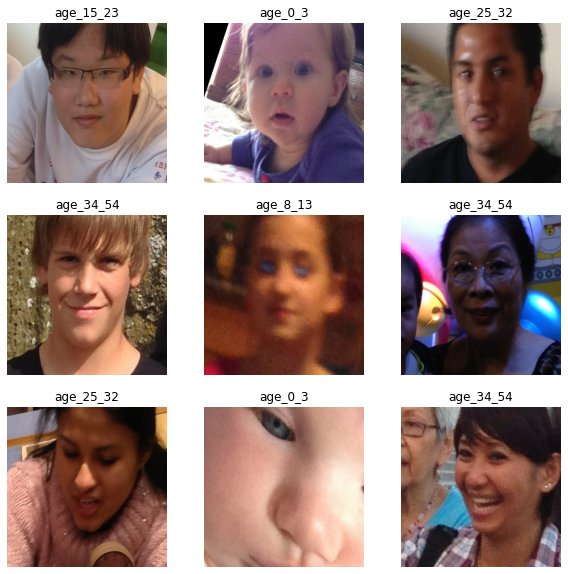

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#normalizing the data to achieve standardization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Data Augmentation
#### Apply the preprocessing layers to your dataset

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1)  
])

In [ ]:
batch_size = 32

def prepare(ds, augment=False):
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

### Inception v3

In [ ]:
#retieving the inception_v3 model from tensorflowhub
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_model = inception_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(256, 256, 3),
    trainable=True)
#other models that we experimented with
#inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
#feature_extractor_model = inception_v3

#inception_resnet_v2 = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
#feature_extractor_model = inception_resnet_v2

#efficientnet_b7 = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"
#feature_extractor_model = efficientnet_b7

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

#Callback to restore best model weights 
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
NUM_EPOCHS = 50
#Fitting the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stop_callback("name"), model_checkpoint_callback])

Epoch 1/50
317/317 [==============================] - ETA: 0s - loss: 1.9151 - acc: 0.3700INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 1007s 3s/step - loss: 1.9151 - acc: 0.3700 - val_loss: 4.7007 - val_acc: 0.3534
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 1.6687 - acc: 0.4412INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 238ms/step - loss: 1.6687 - acc: 0.4412 - val_loss: 3.7786 - val_acc: 0.3791
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 1.5736 - acc: 0.4696INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 238ms/step - loss: 1.5736 - acc: 0.4696 - val_loss: 1.8516 - val_acc: 0.4628
Epoch 4/50
317/317 [==============================] - 65s 206ms/step - loss: 1.5017 - acc: 0.4986 - val_loss: 144.2047 - val_acc: 0.3743
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 1.4403 - acc: 0.5228INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 238ms/step - loss: 1.4403 - acc: 0.5228 - val_loss: 1.4453 - val_acc: 0.5391
Epoch 6/50
317/317 [==============================] - 66s 206ms/step - loss: 1.3563 - acc: 0.5566 - val_loss: 1.4583 - val_acc: 0.5075
Epoch 7/50
317/317 [==============================] - 66s 206ms/step - loss: 1.4597 - acc: 0.5271 - val_loss: 1.8184 - val_acc: 0.4652
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 1.3476 - acc: 0.5708INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 239ms/step - loss: 1.3476 - acc: 0.5708 - val_loss: 1.3979 - val_acc: 0.5071
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 1.2774 - acc: 0.5961INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 238ms/step - loss: 1.2774 - acc: 0.5961 - val_loss: 1.3429 - val_acc: 0.5794
Epoch 10/50
317/317 [==============================] - ETA: 0s - loss: 1.2210 - acc: 0.6195INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 77s 241ms/step - loss: 1.2210 - acc: 0.6195 - val_loss: 1.2547 - val_acc: 0.5929
Epoch 11/50
317/317 [==============================] - 66s 206ms/step - loss: 1.1631 - acc: 0.6385 - val_loss: 1.2827 - val_acc: 0.5810
Epoch 12/50
317/317 [==============================] - 66s 206ms/step - loss: 1.1844 - acc: 0.6313 - val_loss: 1.2947 - val_acc: 0.5984
Epoch 13/50
317/317 [==============================] - ETA: 0s - loss: 1.1286 - acc: 0.6549INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 239ms/step - loss: 1.1286 - acc: 0.6549 - val_loss: 1.1786 - val_acc: 0.6407
Epoch 14/50
317/317 [==============================] - 65s 206ms/step - loss: 1.0922 - acc: 0.6677 - val_loss: 1.2224 - val_acc: 0.6221
Epoch 15/50
317/317 [==============================] - ETA: 0s - loss: 1.0969 - acc: 0.6754INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 76s 240ms/step - loss: 1.0969 - acc: 0.6754 - val_loss: 1.1579 - val_acc: 0.6368
Epoch 16/50
317/317 [==============================] - 66s 206ms/step - loss: 1.0911 - acc: 0.6774 - val_loss: 1.2332 - val_acc: 0.6526
Epoch 17/50
317/317 [==============================] - 65s 206ms/step - loss: 1.0617 - acc: 0.6960 - val_loss: 1.1979 - val_acc: 0.6502
Epoch 18/50
317/317 [==============================] - 65s 206ms/step - loss: 1.0641 - acc: 0.6998 - val_loss: 1.2450 - val_acc: 0.6285
Epoch 19/50
317/317 [==============================] - 65s 206ms/step - loss: 1.1556 - acc: 0.6744 - val_loss: 1.4968 - val_acc: 0.6142
Epoch 20/50
317/317 [==============================] - 65s 206ms/step - loss: 1.0888 - acc: 0.6983 - val_loss: 1.3060 - val_acc: 0.6391
Epoch 21/50
317/317 [==============================] - 65s 206ms/step - loss: 0.9984 - acc: 0.7309 - val_loss: 1.2628 - val_acc: 0.6312
Epoch 22/50
317/317 [==============================] - 66s 2

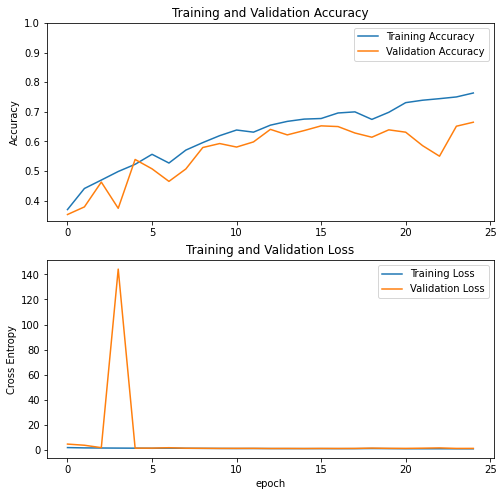

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
#plotting the accuracy and the loss 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Age Predictions

In [ ]:
class_names

['age_0_3',
 'age_15_23',
 'age_25_32',
 'age_34_54',
 'age_4_6',
 'age_55_100',
 'age_8_13']

In [ ]:
#predicting the age of the images
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id
predicted_label_batch=[]
for i in predicted_id.numpy():
    if(i==0):
        predicted_label_batch.append("age_0_3")
    elif(i==1):
        predicted_label_batch.append("age_15_23")
    elif(i==2):
        predicted_label_batch.append("age_25_32")  
    elif(i==3):
        predicted_label_batch.append("age_34_54")
    elif(i==4):
        predicted_label_batch.append("age_4_6") 
    elif(i==5):
        predicted_label_batch.append("age_55_100")
    elif(i==6):
        predicted_label_batch.append("age_8_13")     
print(predicted_label_batch)

['age_34_54', 'age_25_32', 'age_4_6', 'age_0_3', 'age_25_32', 'age_25_32', 'age_15_23', 'age_34_54', 'age_25_32', 'age_25_32', 'age_0_3', 'age_0_3', 'age_8_13', 'age_25_32', 'age_0_3', 'age_25_32', 'age_15_23', 'age_4_6', 'age_4_6', 'age_0_3', 'age_34_54', 'age_8_13', 'age_25_32', 'age_15_23', 'age_4_6', 'age_25_32', 'age_8_13', 'age_15_23', 'age_0_3', 'age_34_54', 'age_0_3', 'age_15_23']


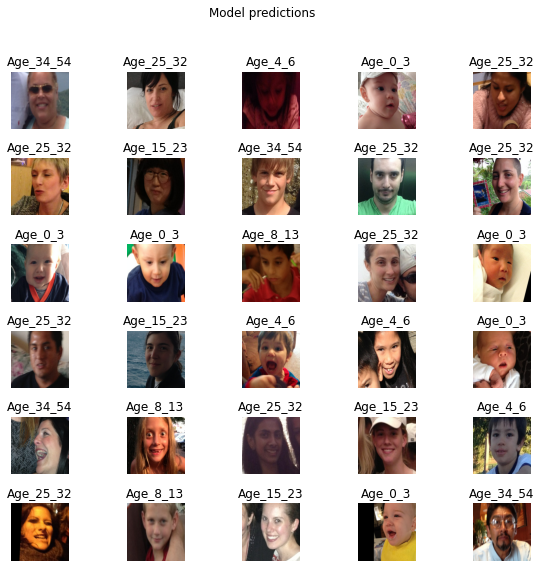

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
t = time.time()
#saving the model to be used later
export_path = "/content/drive/MyDrive/Colab Notebooks/{}".format(int(t))
model.save(export_path)

export_path
#/content/drive/MyDrive/Colab Notebooks/1636862553

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636862553/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636862553/assets


'/content/drive/MyDrive/Colab Notebooks/1636862553'

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

80/80 [==============================] - 5s 58ms/step - loss: 1.2699 - acc: 0.6648
Test accuracy : 0.6648221611976624
